In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, mean_squared_error, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB




# Basic preprocessing
def preprocess(df):
    df_new = df.copy()
    
    # Discard identifiers, style information, timestamps
    df_new = df_new[df_new.columns.difference(['image', 'style', 'reviewTime', 
                                               'reviewerID', 'asin', 'reviewerName', 'unixReviewTime'])]

    # Turn category into binary features
    for cat in df_new.category.unique():
        df_new[cat] = df_new['category'] == cat

    # Drop category column
    df_new.drop(columns=['category'], inplace=True)

    # NaN vote is 0 users found helpful
    df_new.vote.fillna(0, inplace=True)
    
    # Turn vote into binary feature
    df_new.vote = df_new.vote > 0
    # df_new.vote.clip(0, 10)
    # df_new.vote = df_new.vote / 10

    # NaN summary is empty summary
    df_new.summary.fillna('', inplace=True)

    # Turn Booleans into binary variables
    df_new.replace({False: 0, True: 1}, inplace=True)
    
    return df_new
# Remove 'overall' column and add cutoff column applying cutoff
def apply_cutoff(df, cutoff):
    df_new = df.copy()
    
    # Apply cutoff
    cut = df['overall'] > cutoff
    df_new['cutoff'] = cut

    # Drop overall and category
    df_new.drop(columns=['overall'], inplace=True)
    
    # Turn Booleans into binary variables
    df_new.replace({False: 0, True: 1}, inplace=True)
    
    return df_new
def apply_tfidf(df, review_vectorizer, summary_vectorizer):
    review_matrix = pd.DataFrame(data=review_vectorizer.transform(df.reviewText).toarray(), columns='R_' + review_vectorizer.get_feature_names_out())
    summary_matrix = pd.DataFrame(data=summary_vectorizer.transform(df.summary).toarray(), columns='S_' + summary_vectorizer.get_feature_names_out())
    df_new = pd.concat([df, review_matrix, summary_matrix], axis=1)
    df_new.drop(columns=['summary', 'reviewText'], inplace=True)
    return df_new


# Processing the data - I
# Preprocessing of training data
def load_and_process_data():
    training_df = pd.read_csv('../data/Training.csv')
    test_df = pd.read_csv('../data/Test.csv')

    proc_training_df = apply_cutoff(preprocess(training_df), 1)

    # Set cutoff to be the label; define data_x and y accordingly
    data_x = proc_training_df.drop('cutoff', axis=1)
    data_y = proc_training_df['cutoff']

    # Fit TF-IDF vectorizer for 'reviewText' and 'summary' features, creating max. 11500 features.
    r_vectorizer = TfidfVectorizer(max_features=11500, stop_words='english', ngram_range=(1, 3))
    s_vectorizer = TfidfVectorizer(max_features=11500, stop_words='english', ngram_range=(1, 3))
    r_vectorizer.fit(data_x.reviewText)
    s_vectorizer.fit(data_x.summary)

    # Apply TF-IDF vectorization 
    data_x = apply_tfidf(data_x, r_vectorizer, s_vectorizer)

    # Apply robust scaling
    scaler = preprocessing.RobustScaler()
    data_x = pd.DataFrame(scaler.fit_transform(data_x), columns=data_x.columns, index=data_x.index)

    # Let us reduce the number of features by eliminating the statistically least correlated ones.
    relcols = data_x.columns[abs(data_x.corrwith(data_y)) > 0.01]


    # We will go with these columns.
    data_x = data_x[relcols]

    return data_x, data_y

def create_splits(data_x, data_y, n_splits):
    # 5-fold cross validation
    kf = KFold(n_splits=n_splits, shuffle=True)
    splits = []
    for train_idx, val_idx in kf.split(data_x, data_y):
        # Apply split
        x_train, x_val = data_x.iloc[train_idx], data_x.iloc[val_idx]
        y_train, y_val = data_y.iloc[train_idx], data_y.iloc[val_idx]
        
        # Reset indices
        x_train.reset_index(drop=True, inplace=True)
        y_train.reset_index(drop=True, inplace=True)
        x_val.reset_index(drop=True, inplace=True)
        y_val.reset_index(drop=True, inplace=True)
        splits.append((x_train, x_val, y_train, y_val))
    return splits



In [3]:

X_DATA, Y_DATA = load_and_process_data()

test_splits = create_splits(X_DATA, Y_DATA, 5)

print(len(test_splits[0][1]), len(X_DATA))

5838 29189


# Define and create the population data

In [7]:
Q_MEAN = 0.5
EPOCH = 2
POPULATION_SIZE = 10000
TRAIN_DIM = 100
STEP = 1

In [5]:
import numpy as np

def initialize_with_str_seed(init_str):
    """
    Initializes random number generator with seed corresponding to given input string init_str.
    :param init_str: Initialization string according to which seed will be computed. Seed is the sum of the ASCII
                     values of each character in init_str.
    """
    rnd_val = 0
    if init_str:
        for c in init_str:
            rnd_val += ord(c)
    np.random.seed(rnd_val)

def gen_data(n, d, seed = None):
    if seed:
        initialize_with_str_seed(seed)
    p = (1.0 + np.sqrt(max(2 * Q_MEAN - 1, 1 - 2 * Q_MEAN))) / 2 
    data = np.random.choice([-1, 1], (n, d), p=[1 -p, p])
    data_y = np.random.choice([0, 1], n, p=[1 -p, p])
    return data, data_y

def gen_valid(n, d, seed = None):
    if seed:
        initialize_with_str_seed(seed)
    
    n = int(n/10)
    
    p = (1.0 + np.sqrt(max(2 * Q_MEAN - 1, 1 - 2 * Q_MEAN))) / 2 
    data = np.random.choice([-1, 1], (n, d), p=[1 -p, p])
    data_y = np.random.choice([0, 1], n, p=[1 -p, p])
    return data, data_y

In [8]:
x_population, y_population = gen_data(POPULATION_SIZE, TRAIN_DIM)
x_valid, y_valid = gen_data(int(POPULATION_SIZE/500), TRAIN_DIM)

# Define the evaluation functions

In [12]:
import sys
sys.path.append("..")
from mechanism.mechanized_models import Mechanism
from mechanism.mechanized_models import MechanizedGaussianNB, MechanizedLogisticRegression, MechanizedOneVSRest, MechanizedDecisionTree
from mechanism.mechanized_models import MechanizedGridSearchCV

def hyper_parameter(splits):
    x_train, x_val, y_train, y_val = splits[0]
    estimator = MechanizedLogisticRegression(max_iter=1500)
    estimator.choose_mechanism(Mechanism.GAUSSIAN)
    gs_cls = MechanizedOneVSRest(estimator = estimator)
    gs_cls.choose_mechanism(Mechanism.GAUSSIAN)

    params_LR = {'estimator__C': np.logspace(-0.2, 0.7, num = 10)}
    gs_LR = GridSearchCV(estimator=gs_cls, param_grid=params_LR, cv = 2, verbose=2, scoring='f1_macro')
    gs_LR.fit(x_train, y_train)


BEST_C = 1.5848931924611134
'''
C=1.5848931924611134, max_iter=1500
'''




def eval_multiple_rounds(stepped_rounds, mechanism, non_adaptive_num):
    generalization_error_list = []
    for r in stepped_rounds:
        estimator = MechanizedLogisticRegression(C = BEST_C, max_iter = r, mechanism = mechanism, solver = 'sag')
        generalization_error_list.append(eval(non_adaptive_num, estimator, mechanism))
    return generalization_error_list



# Evaluation the O(1) adaptivity program

In [ ]:
def eval_const(round, train_size, mechanism):
    # f1_scores, acc_scores, models = [], [], [], [], []
    x_train, y_train = x_population[:train_size], y_population[:train_size]    
    model = MechanizedLogisticRegression(C = BEST_C, max_iter = round, mechanism = mechanism)

    model.fit(x_train, y_train)
    # Predict
    y_pred = model.predict(x_valid)

    return mean_squared_error(y_valid, y_pred)

def eval_const_rounds(round, mechanism, stepped_non_adaptive_num):
    generalization_error_list = []
    for train_size in stepped_non_adaptive_num:
        generalization_error_list.append(eval_const(round, train_size, mechanism))
    return generalization_error_list

In [16]:

def plot_error(rounds, generalization_error, mechanism):
    plt.plot(rounds, generalization_error, label = mechanism)
    plt.xlabel("Queries")
    plt.ylabel("RMSE (Generalization Error) for adaptive queries")
    plt.legend()
    plt.grid()

stepped_non_adaptive_num = range(100, 1000, 10)
round = 5


In [ ]:

baseline_generalization_error_list = eval_const_rounds(round, Mechanism(mechanism_type = Mechanism.MechanismType.NONE), stepped_non_adaptive_num)
# baseline_generalization_error_list = [0.47190818773552584, 0.473107228502912, 0.473792394655704, 0.47070914696813976, 0.4659129838985954, 0.4720794792737239, 0.47447756080849607, 0.473107228502912, 0.4775608084960603, 0.47619047619047616, 0.4712230215827338, 0.47447756080849607, 0.47567660157588215, 0.473792394655704, 0.47533401849948614]
print(baseline_generalization_error_list)

In [ ]:
gaussian_generalization_error_list = eval_const_rounds(round, Mechanism(mechanism_type = Mechanism.MechanismType.GAUSSIAN, sigma = 0.1), stepped_non_adaptive_num)
# gaussian_generalization_error_list = [0.3984241178485783, 0.4035628639945187, 0.39482699554642003, 0.3977389516957862, 0.3977389516957862, 0.3917437478588558, 0.3975676601575882, 0.39585474477560806, 0.38866050017129156, 0.3970537855429942, 0.39568345323741005, 0.3857485440219253, 0.38506337786913325, 0.39157245632065774, 0.3871188763275094]

print(gaussian_generalization_error_list)


In [ ]:
threshold_generalization_error_list = eval_const_rounds(round, Mechanism(mechanism_type = Mechanism.MechanismType.THRESHOLD, sigma = 0.5, hold_frac = 0.5, threshold = 0.8), stepped_non_adaptive_num)
# gaussian_generalization_error_list = [0.3984241178485783, 0.4035628639945187, 0.39482699554642003, 0.3977389516957862, 0.3977389516957862, 0.3917437478588558, 0.3975676601575882, 0.39585474477560806, 0.38866050017129156, 0.3970537855429942, 0.39568345323741005, 0.3857485440219253, 0.38506337786913325, 0.39157245632065774, 0.3871188763275094]

print(threshold_generalization_error_list)

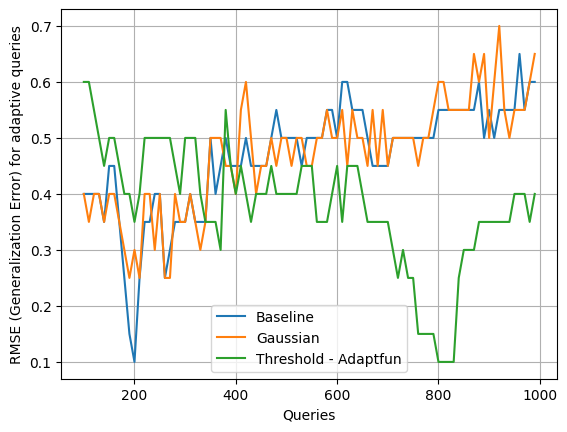

In [25]:
import math

plt.figure()
x_range = stepped_non_adaptive_num
plot_error(x_range, (baseline_generalization_error_list), "Baseline")
plot_error(x_range, (gaussian_generalization_error_list), "Gaussian")
plot_error(x_range, (threshold_generalization_error_list), "Threshold - Adaptfun")
plt.show()

# Evaluate the O(n*m) Adaptivity Program

In [90]:
from sklearn.multiclass import OneVsRestClassifier

class MechanizedLogisticRegression(LogisticRegression):

    def __init__(self, penalty="l2", *, dual=False, tol=0.0001, C=1, 
                 fit_intercept=True, intercept_scaling=1, class_weight=None,
                 random_state=None, solver="lbfgs", max_iter=100, multi_class="auto", 
                 verbose=0, warm_start=False, n_jobs=None, 
                 l1_ratio=None,
                 mechanism = Mechanism(Mechanism.MechanismType.NONE)):
        super(MechanizedLogisticRegression, self).__init__(penalty, dual=dual, 
                                                           tol = tol, C = C, fit_intercept = fit_intercept, 
                                                           intercept_scaling = intercept_scaling,
                                                           class_weight = class_weight, 
                                                           random_state = random_state, 
                                                           solver = solver, 
                                                           max_iter = max_iter, 
                                                           multi_class = multi_class, 
                                                           verbose = verbose, 
                                                           warm_start = warm_start, 
                                                           n_jobs = n_jobs, 
                                                           l1_ratio = l1_ratio)
        self.mechanism = mechanism

    def fit_threshold(self, x_train, y_train):
        size = len(x_train)
        hold_size, train_size = int(size  * (self.mechanism.hold_frac)), int(size  * (1.0 - self.mechanism.hold_frac))
        x_train, y_train, x_hold, y_hold = x_train[hold_size:], y_train[hold_size:], x_train[:hold_size], y_train[:hold_size]
        train_result = super(MechanizedLogisticRegression, self).fit(x_train, y_train)
        train_pred = train_result.predict(x_train)
        hold_result = super(MechanizedLogisticRegression, self).fit(x_hold, y_hold)
        hold_pred = hold_result.predict(x_hold)
        if abs(accuracy_score(train_pred, y_train) - accuracy_score(hold_pred, y_hold)) >= self.mechanism.noisy_thresh + np.random.laplace(0, 4 * self.mechanism.sigma):
            self.mechanism.noisy_thresh = self.mechanism.threshold + np.random.laplace(0, 2 * self.mechanism.sigma)
            x_noise =  np.random.laplace(0, 2 * self.mechanism.sigma, x_hold.shape)
            return super(MechanizedLogisticRegression, self).fit(x_hold + x_noise, y_hold)
        else:
            return train_result

    def fit_gaussian(self, x_train, y_train):
        x_noise = np.random.normal(0, self.mechanism.sigma, x_train.shape) 
        noised_x = x_train + x_noise        
        ################ Gaussian Noise Added to Labels ################
        # y_noise = np.random.normal(0, 0.1, y_train.shape) 
        # noised_y = y_train + y_noise
        # lab = preprocessing.LabelEncoder()
        # y_transformed = pd.Series(
        # lab.fit_transform(noised_y), 
        # y_train.index,
        # y_train.dtype,
        # y_train.name,
        # y_train.copy
        # )
        # y_transformed = lab.fit_transform(noised_y)

        result = super(MechanizedLogisticRegression, self).fit(noised_x, y_train)
        if isinstance(result, LogisticRegression):
            return self
        else:
            return result



    def fit(self, x_train, y_train):
        if self.mechanism.mechanism_type ==  Mechanism.MechanismType.NONE:
            print("in Baseline Logistic Regression")
            result = super(MechanizedLogisticRegression, self).fit(x_train, y_train)
            if isinstance(result, LogisticRegression):
                return self
            else:
                return result
        elif self.mechanism.mechanism_type ==  Mechanism.MechanismType.GAUSSIAN:
            print("in gaussian Mechanized Logistic Regression")
            return self.fit_gaussian(x_train, y_train)
        
        elif self.mechanism.mechanism_type ==  Mechanism.MechanismType.THRESHOLD:
            print("in Threshold Mechanized Logistic Regression")
            return self.fit_threshold(x_train, y_train)
            
        else:
            result = super(MechanizedLogisticRegression, self).fit(x_train, y_train)
            if isinstance(result, LogisticRegression):
                return self
            else:
                return result
           
    def choose_mechanism(self, mech):
        self.mechanism = mech


class MechanizedOneVSRest(OneVsRestClassifier):
    
    def __init__(self, estimator, *, n_jobs=None, verbose=0,
                 mechanism = Mechanism(Mechanism.MechanismType.NONE)):
        super(MechanizedOneVSRest, self).__init__(estimator = estimator, n_jobs = n_jobs, verbose = verbose)
        self.mechanism = mechanism
    
    def fit_threshold(self, x_train, y_train):
        size = len(x_train)
        hold_size, train_size = int(size  * (self.mechanism.hold_frac)), int(size  * (1.0 - self.mechanism.hold_frac))
        x_train, y_train, x_hold, y_hold = x_train[hold_size:], y_train[hold_size:], x_train[:hold_size], y_train[:hold_size]
        train_result = super(MechanizedOneVSRest, self).fit(x_train, y_train)
        train_pred = train_result.predict(x_train)
        hold_result = super(MechanizedOneVSRest, self).fit(x_hold, y_hold)
        hold_pred = hold_result.predict(x_hold)
        if abs(accuracy_score(train_pred, y_train) - accuracy_score(hold_pred, y_hold)) >= self.mechanism.noisy_thresh + np.random.laplace(self.mechanism.mu, 4 * self.mechanism.sigma):
            self.mechanism.noisy_thresh = self.mechanism.threshold + np.random.laplace(self.mechanism.mu, 2 * self.mechanism.sigma)
            x_noise =  np.random.laplace(self.mechanism.mu, self.mechanism.sigma, x_hold.shape)
            return super(MechanizedOneVSRest, self).fit(x_hold + x_noise, y_hold)
        else:
            return train_result        

    def fit(self, x_train, y_train):
        if self.mechanism.mechanism_type ==  Mechanism.MechanismType.NONE:
            print("in Baseline Mechanized One v.s. Rest")
            result = super(MechanizedOneVSRest, self).fit(x_train, y_train)
            if isinstance(result, OneVsRestClassifier):
                return self
            else:
                return result
        elif self.mechanism.mechanism_type ==  Mechanism.MechanismType.GAUSSIAN:
            print("in Gaussian Mechanized One v.s. Rest")
            x_noise = np.random.normal(0, 0.1, x_train.shape) 
            noised_x = x_train + x_noise
            result = super(MechanizedOneVSRest, self).fit(noised_x, y_train)
            if isinstance(result, OneVsRestClassifier):
                return self
            else:
                return result
        elif self.mechanism.mechanism_type ==  Mechanism.MechanismType.THRESHOLD:
            print("in Threshold Mechanized One v.s. Rest")
            return self.fit_threshold(x_train, y_train)
        else:
            result = super(MechanizedOneVSRest, self).fit(x_train, y_train)
            if isinstance(result, OneVsRestClassifier):
                return self
            else:
                return result

    def choose_mechanism(self, mech):
        self.mechanism = mech


In [104]:
def eval_nm(round, train_size, mechanism):
    # f1_scores, acc_scores, models = [], [], [], [], []
    x_train, y_train = x_population[:train_size], y_population[:train_size]
    
    estimator = MechanizedLogisticRegression(C = BEST_C, max_iter = round, mechanism = mechanism, solver = 'lbfgs', random_state = np.random.randint(1000000))
    model = MechanizedOneVSRest(estimator, mechanism = mechanism)

    model.fit(x_train, y_train)
    # Predict
    y_pred = model.predict(x_valid)

    return mean_squared_error(y_valid, y_pred)


def eval_nm_rounds(stepped_rounds, mechanism, non_adaptive_num):
    generalization_error_list = []
    for r in stepped_rounds:
        # estimator = MechanizedLogisticRegression(C = BEST_C, max_iter = r, mechanism = mechanism, solver = 'sag')
        generalization_error_list.append(eval_nm(r, non_adaptive_num, mechanism))
    return generalization_error_list

In [185]:
stepped_rounds = range(100, 1100, 10)
non_adaptive_num = 1000

In [186]:
baseline_generalization_error_list = eval_nm_rounds(stepped_rounds, Mechanism(mechanism_type = Mechanism.MechanismType.NONE), non_adaptive_num)
print((baseline_generalization_error_list))

in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression
in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression
in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression
in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression
in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression
in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression
in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression
in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression
in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression
in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression
in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression
in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression
in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression
in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression
in Baseline Mechanized One v.s. Re

In [194]:

gaussian_generalization_error_list = eval_nm_rounds(stepped_rounds, Mechanism(mechanism_type = Mechanism.MechanismType.GAUSSIAN, sigma = 0.08), non_adaptive_num)
print(gaussian_generalization_error_list) 
# = [0.3984241178485783, 0.4035628639945187, 0.39482699554642003, 0.3977389516957862, 0.3977389516957862, 0.3917437478588558, 0.3975676601575882, 0.39585474477560806, 0.38866050017129156, 0.3970537855429942, 0.39568345323741005, 0.3857485440219253, 0.38506337786913325, 0.39157245632065774, 0.3871188763275094]


in Gaussian Mechanized One v.s. Rest
in gaussian Mechanized Logistic Regression
in Gaussian Mechanized One v.s. Rest
in gaussian Mechanized Logistic Regression
in Gaussian Mechanized One v.s. Rest
in gaussian Mechanized Logistic Regression
in Gaussian Mechanized One v.s. Rest
in gaussian Mechanized Logistic Regression
in Gaussian Mechanized One v.s. Rest
in gaussian Mechanized Logistic Regression
in Gaussian Mechanized One v.s. Rest
in gaussian Mechanized Logistic Regression
in Gaussian Mechanized One v.s. Rest
in gaussian Mechanized Logistic Regression
in Gaussian Mechanized One v.s. Rest
in gaussian Mechanized Logistic Regression
in Gaussian Mechanized One v.s. Rest
in gaussian Mechanized Logistic Regression
in Gaussian Mechanized One v.s. Rest
in gaussian Mechanized Logistic Regression
in Gaussian Mechanized One v.s. Rest
in gaussian Mechanized Logistic Regression
in Gaussian Mechanized One v.s. Rest
in gaussian Mechanized Logistic Regression
in Gaussian Mechanized One v.s. Rest
in 

In [189]:
threshold_generalization_error_list = eval_nm_rounds(stepped_rounds, Mechanism(mechanism_type = Mechanism.MechanismType.THRESHOLD, sigma = 0.08, hold_frac = 0.7, threshold = 0.9), non_adaptive_num)
# gaussian_generalization_error_list = [0.3984241178485783, 0.4035628639945187, 0.39482699554642003, 0.3977389516957862, 0.3977389516957862, 0.3917437478588558, 0.3975676601575882, 0.39585474477560806, 0.38866050017129156, 0.3970537855429942, 0.39568345323741005, 0.3857485440219253, 0.38506337786913325, 0.39157245632065774, 0.3871188763275094]

print(threshold_generalization_error_list)

in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Reg

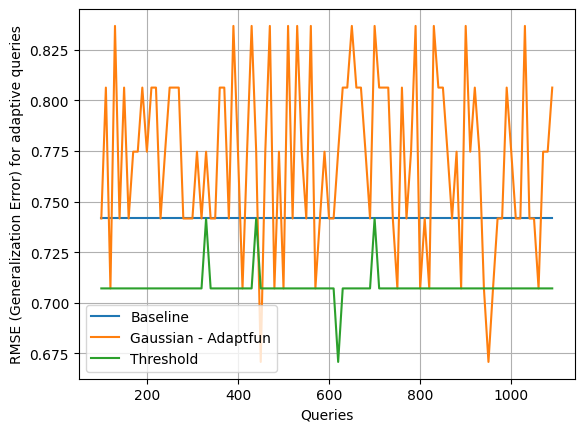

In [190]:
plt.figure()
x_range = stepped_rounds
plot_error(x_range, np.sqrt(baseline_generalization_error_list), "Baseline")
plot_error(x_range, np.sqrt(gaussian_generalization_error_list), "Gaussian - Adaptfun")
plot_error(x_range, np.sqrt(threshold_generalization_error_list), "Threshold")
plt.show()

# Evaluate the O(n) Adaptivity Program

In [150]:
def eval_n(round, train_size, mechanism):
    # f1_scores, acc_scores, models = [], [], [], [], []
    x_train, y_train = x_population[:train_size], y_population[:train_size]    
    model = MechanizedLogisticRegression(C = BEST_C, max_iter = round, mechanism = mechanism)

    model.fit(x_train, y_train)
    # Predict
    y_pred = model.predict(x_valid)

    return mean_squared_error(y_valid, y_pred)

def eval_multiple_rounds(stepped_rounds, mechanism, non_adaptive_num):
    generalization_error_list = []
    for r in stepped_rounds:
        generalization_error_list.append(eval_n(r, non_adaptive_num, mechanism))
    return generalization_error_list


In [179]:
stepped_rounds = range(100, 1100, 10)
non_adaptive_num = 1000



In [180]:

baseline_generalization_error_list = eval_multiple_rounds(stepped_rounds, Mechanism(mechanism_type = Mechanism.MechanismType.NONE), non_adaptive_num)


in Baseline Logistic Regression
in Baseline Logistic Regression
in Baseline Logistic Regression
in Baseline Logistic Regression
in Baseline Logistic Regression
in Baseline Logistic Regression
in Baseline Logistic Regression
in Baseline Logistic Regression
in Baseline Logistic Regression
in Baseline Logistic Regression
in Baseline Logistic Regression
in Baseline Logistic Regression
in Baseline Logistic Regression
in Baseline Logistic Regression
in Baseline Logistic Regression
in Baseline Logistic Regression
in Baseline Logistic Regression
in Baseline Logistic Regression
in Baseline Logistic Regression
in Baseline Logistic Regression
in Baseline Logistic Regression
in Baseline Logistic Regression
in Baseline Logistic Regression
in Baseline Logistic Regression
in Baseline Logistic Regression
in Baseline Logistic Regression
in Baseline Logistic Regression
in Baseline Logistic Regression
in Baseline Logistic Regression
in Baseline Logistic Regression
in Baseline Logistic Regression
in Basel

In [181]:
print(gaussian_generalization_error_list)

[0.45, 0.3, 0.35, 0.4, 0.5, 0.5, 0.45, 0.6, 0.7, 0.6, 0.55, 0.5, 0.5, 0.65, 0.65, 0.65, 0.6, 0.6, 0.6, 0.65, 0.7, 0.65, 0.7, 0.7, 0.65, 0.6, 0.6, 0.65, 0.6, 0.7, 0.45, 0.5, 0.6, 0.65, 0.65, 0.8, 0.6, 0.45, 0.55, 0.55, 0.55, 0.55, 0.55, 0.55, 0.55, 0.6, 0.6, 0.65, 0.65, 0.6, 0.55, 0.6, 0.65, 0.6, 0.65, 0.65, 0.6, 0.6, 0.6, 0.6, 0.65, 0.6, 0.7, 0.65, 0.55, 0.6, 0.45, 0.5, 0.55, 0.6, 0.55, 0.6, 0.6, 0.55, 0.6, 0.5, 0.55, 0.45, 0.45, 0.45, 0.55, 0.55, 0.55, 0.55, 0.6, 0.55, 0.5, 0.6, 0.6, 0.65, 0.65, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6]


In [182]:
gaussian_generalization_error_list = eval_multiple_rounds(stepped_rounds, Mechanism(mechanism_type = Mechanism.MechanismType.GAUSSIAN, sigma = 0.1), non_adaptive_num)


in gaussian Mechanized Logistic Regression
in gaussian Mechanized Logistic Regression
in gaussian Mechanized Logistic Regression
in gaussian Mechanized Logistic Regression
in gaussian Mechanized Logistic Regression
in gaussian Mechanized Logistic Regression
in gaussian Mechanized Logistic Regression
in gaussian Mechanized Logistic Regression
in gaussian Mechanized Logistic Regression
in gaussian Mechanized Logistic Regression
in gaussian Mechanized Logistic Regression
in gaussian Mechanized Logistic Regression
in gaussian Mechanized Logistic Regression
in gaussian Mechanized Logistic Regression
in gaussian Mechanized Logistic Regression
in gaussian Mechanized Logistic Regression
in gaussian Mechanized Logistic Regression
in gaussian Mechanized Logistic Regression
in gaussian Mechanized Logistic Regression
in gaussian Mechanized Logistic Regression
in gaussian Mechanized Logistic Regression
in gaussian Mechanized Logistic Regression
in gaussian Mechanized Logistic Regression
in gaussian

In [183]:
threshold_generalization_error_list = eval_multiple_rounds(stepped_rounds, Mechanism(mechanism_type = Mechanism.MechanismType.THRESHOLD, sigma = 0.08, hold_frac = 0.7, threshold = 0.8), non_adaptive_num)
# gaussian_generalization_error_list = [0.3984241178485783, 0.4035628639945187, 0.39482699554642003, 0.3977389516957862, 0.3977389516957862, 0.3917437478588558, 0.3975676601575882, 0.39585474477560806, 0.38866050017129156, 0.3970537855429942, 0.39568345323741005, 0.3857485440219253, 0.38506337786913325, 0.39157245632065774, 0.3871188763275094]

print(threshold_generalization_error_list)

in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic

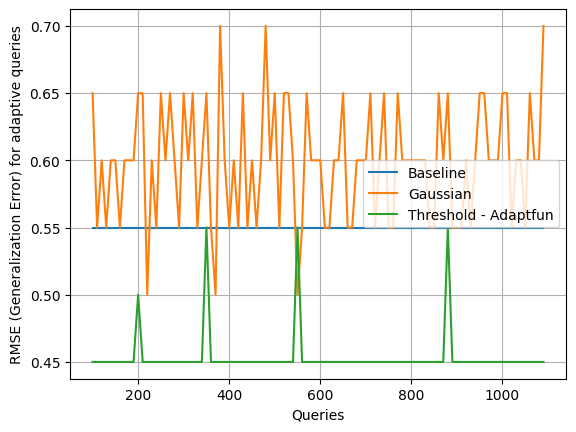

In [184]:
plt.figure()
x_range = stepped_rounds
plot_error(x_range, baseline_generalization_error_list, "Baseline")
plot_error(x_range, gaussian_generalization_error_list, "Gaussian")
plot_error(x_range, threshold_generalization_error_list, "Threshold - Adaptfun")
plt.show()


In [195]:
stepped_non_adaptive_num = range(100, 10000, 100)
round = 10

In [196]:

baseline_generalization_error_list = eval_const_rounds(round, Mechanism(mechanism_type = Mechanism.MechanismType.NONE), stepped_non_adaptive_num)
# baseline_generalization_error_list = [0.47190818773552584, 0.473107228502912, 0.473792394655704, 0.47070914696813976, 0.4659129838985954, 0.4720794792737239, 0.47447756080849607, 0.473107228502912, 0.4775608084960603, 0.47619047619047616, 0.4712230215827338, 0.47447756080849607, 0.47567660157588215, 0.473792394655704, 0.47533401849948614]
print(baseline_generalization_error_list)


in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression
in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression
in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression
in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression
in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression
in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression
in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression
in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression
in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression
in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression
in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression
in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression
in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression
in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression
in Baseline Mechanized One v.s. Re

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

in Baseline Logistic Regression
in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression
in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression
in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression
in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression
in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression
in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression
in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression
in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression
in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression
in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression
in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression
in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression
in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression
in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression
in

In [199]:
threshold_generalization_error_list = eval_const_rounds(round, Mechanism(mechanism_type = Mechanism.MechanismType.THRESHOLD, sigma = 0.08, hold_frac = 0.7, threshold = 0.9), stepped_non_adaptive_num)
# gaussian_generalization_error_list = [0.3984241178485783, 0.4035628639945187, 0.39482699554642003, 0.3977389516957862, 0.3977389516957862, 0.3917437478588558, 0.3975676601575882, 0.39585474477560806, 0.38866050017129156, 0.3970537855429942, 0.39568345323741005, 0.3857485440219253, 0.38506337786913325, 0.39157245632065774, 0.3871188763275094]

print(threshold_generalization_error_list)



in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Reg

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logist

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Reg

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression


/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Reg

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Reg

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression


/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression


/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression


/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression


/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
[0.35, 0.45, 0.4, 0.3, 0.35, 0.3, 0.45, 0.45, 0.45, 0.5, 0.5, 0.55, 0.55, 0.45, 0.5, 0.5, 0.55, 0.5, 0.55, 0.6, 0.55, 0.55, 0.5, 0.5, 0.5, 0.45, 0.5, 0.6, 0.7, 0.65, 0.7, 0.65, 0.55, 0.65, 0.55, 0.6, 0.55, 0.55, 0.55, 0.65, 0.7, 0.7, 0.7, 0.7, 0.65, 0.6, 0.65, 0.7, 0.7, 0.65, 0.65, 0.65, 0.65, 0.65, 0.6, 0.65, 0.65, 0.55, 0.

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [205]:
gaussian_generalization_error_list = eval_const_rounds(round, Mechanism(mechanism_type = Mechanism.MechanismType.GAUSSIAN, sigma = 0.1), stepped_non_adaptive_num)
# gaussian_generalization_error_list = [0.3984241178485783, 0.4035628639945187, 0.39482699554642003, 0.3977389516957862, 0.3977389516957862, 0.3917437478588558, 0.3975676601575882, 0.39585474477560806, 0.38866050017129156, 0.3970537855429942, 0.39568345323741005, 0.3857485440219253, 0.38506337786913325, 0.39157245632065774, 0.3871188763275094]

print(gaussian_generalization_error_list)

in Gaussian Mechanized One v.s. Rest
in gaussian Mechanized Logistic Regression
in Gaussian Mechanized One v.s. Rest
in gaussian Mechanized Logistic Regression
in Gaussian Mechanized One v.s. Rest
in gaussian Mechanized Logistic Regression
in Gaussian Mechanized One v.s. Rest
in gaussian Mechanized Logistic Regression
in Gaussian Mechanized One v.s. Rest
in gaussian Mechanized Logistic Regression
in Gaussian Mechanized One v.s. Rest
in gaussian Mechanized Logistic Regression
in Gaussian Mechanized One v.s. Rest
in gaussian Mechanized Logistic Regression
in Gaussian Mechanized One v.s. Rest
in gaussian Mechanized Logistic Regression
in Gaussian Mechanized One v.s. Rest
in gaussian Mechanized Logistic Regression
in Gaussian Mechanized One v.s. Rest
in gaussian Mechanized Logistic Regression
in Gaussian Mechanized One v.s. Rest
in gaussian Mechanized Logistic Regression
in Gaussian Mechanized One v.s. Rest
in gaussian Mechanized Logistic Regression
in Gaussian Mechanized One v.s. Rest
in 

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

in gaussian Mechanized Logistic Regression
in Gaussian Mechanized One v.s. Rest
in gaussian Mechanized Logistic Regression
in Gaussian Mechanized One v.s. Rest
in gaussian Mechanized Logistic Regression
in Gaussian Mechanized One v.s. Rest
in gaussian Mechanized Logistic Regression
in Gaussian Mechanized One v.s. Rest
in gaussian Mechanized Logistic Regression
in Gaussian Mechanized One v.s. Rest
in gaussian Mechanized Logistic Regression
in Gaussian Mechanized One v.s. Rest
in gaussian Mechanized Logistic Regression
in Gaussian Mechanized One v.s. Rest
in gaussian Mechanized Logistic Regression
in Gaussian Mechanized One v.s. Rest
in gaussian Mechanized Logistic Regression
in Gaussian Mechanized One v.s. Rest
in gaussian Mechanized Logistic Regression
in Gaussian Mechanized One v.s. Rest
in gaussian Mechanized Logistic Regression
in Gaussian Mechanized One v.s. Rest
in gaussian Mechanized Logistic Regression
in Gaussian Mechanized One v.s. Rest
in gaussian Mechanized Logistic Regressi

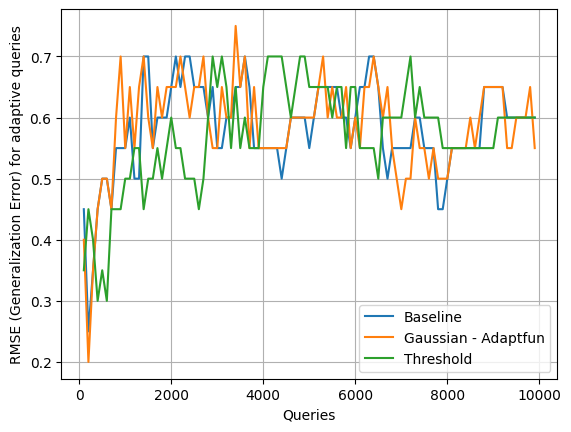

In [206]:
plt.figure()
x_range = stepped_non_adaptive_num
plot_error(x_range, (baseline_generalization_error_list), "Baseline")
plot_error(x_range, (gaussian_generalization_error_list), "Gaussian - Adaptfun")
plot_error(x_range, (threshold_generalization_error_list), "Threshold")
plt.show()